# Transformer Fraud Classifier - Overfitted 
---
 __This is and example of how NOT to train a Neural Net__

---
#### Introduction
In one of the examples of RNN's we noted that there was a whiff of overfitting. Overfitting is a typical problem with machine learning, one which Neural Nets tend to suffer easier from than for instance tree based models. It's an important enough potential problem to spend some time on it.

Overfitting happens when a model 'memorizes' the traning data, it can get very good at finding the __exact__ cases in the training data, but not 'generalize' at all.

Neural Nets are said to have a *capacity* which increases as we give them more 'parameters', i.e weights, to work with. So the more and wider the layers we use, the higher the dimensions of the embedding etc... the more capacity the model will have. 

And at some point the capacity can get big enough to 'remember' the entire training set,  which is bad because if we get slightly different cases in the real world our model might not find them. Ideally we want our model to 'generalize' so it can find slightly different cases.

A good visual aid is trying to draw a decision boundary to separate for instance rectangles from circles. The overfit example is a much more complex curve.

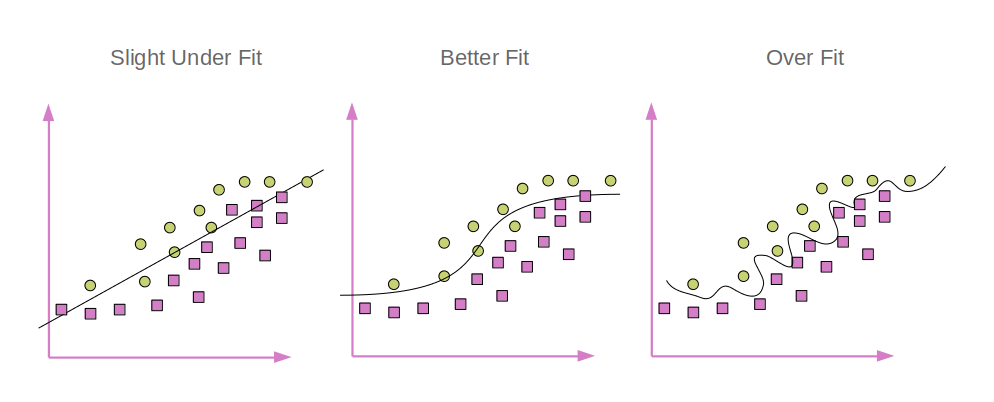

This is exactly what happens to neural nets. Neural Nets are in fact function approximators. The more parameters and layers they have, the more complex functions they can build. But more complex does not always imply 'better' or more 'general'.

#### Data-sets
The reason we have 3 data-sets in the examples, is exactly to monitor overfit and information leakage. The validation data set can be used to monitor overfit during training, though it's not always easy to spot. The test set is so we can have an independent data set with unseen data which can be checked if the model generalizes well.

#### Avoiding overfit
There are a lot of ways to try and avoid overfit. Some of the most commonly use measures are;
- Use more data
- Avoid features that make it relatively easy to identify single transactions (exact times, postal-codes, ...)
- Make the model less complex (Less layers, less weights per layer)
- Run less epochs. (Shorter training cycle, stop when we spot overfit)
- Regularize the model
- Use drop-out

Our models have used regularization (__weight decay__) and __drop-out__ in the previous examples to avoid overfit. Let's maybe quickly explain these.

##### Weight decay
L2-Regularization and weight-decay are 2 very similar techniques, though implemented slightly differently they basically achieve the same goal. L2-Regularization penalizes the loss based on the properties of the weights. During training Neural Nets will try to minimize a loss value. That loss is some function $L$ of the predicted output $\hat{Y}$ and expected output $Y$. It gives a measure of how close our prediction is to the expected value. 

$l = L(\hat{Y}, Y)$

L2-Regularization adds a term to the loss, making that term a sort of penalty (It needs to be as small as possible as the NN will try to minimize the loss). The term is a function $R$ of the weights $W$ in the model, multiplied by some value $\lambda$. The most frequently used functions are taking the L2 or L1 norm of the weights or using a combination of both (elastic).

$l = L(\hat{Y}, Y) + \lambda R(W)$

By putting in this extra penalty we entice the model to keep the weights small and thus get a simpler model. Weight decay achieves more of less the same but it subtracts from the weights during the gradient denscent process.

Our models have used a default __weight decay of 0.01__ which is very similar to the an L2 regularization with a $\lambda$ of 0.01

##### Drop out

Drop out is a fairly simple concept. It is a layer that sets the of weight of a node in the layer to 0 with a give probability. For instance in below example a drop out with P=0.25 would __at random__ set one of the values of the middle layer to 0.0 during training. Which is the equivalent of effectively dropping a 'hidden/latent' feature. 

It introduces some randomness which in general is good to prevent overfitting.

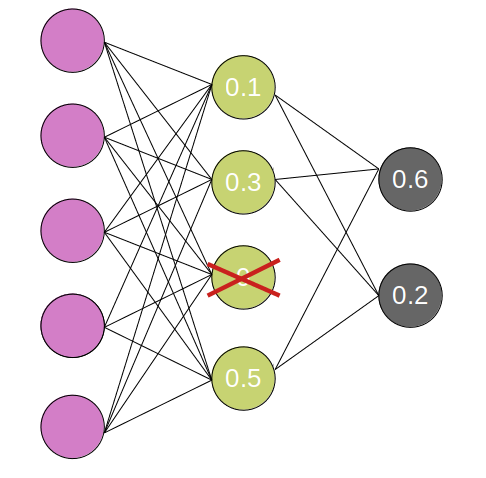

Initially it might not be clear why this help, but a bit of a hand-wavy explanation to build some intuition might go as follows. Assume for arguments sake that the above 4 nodes in the hidden layer each describe a feature of a payment, for instance 'high_amount', 'risky_category', 'high_age' and 'female'. If we get a set of fraud where these values are higher than for non-frauds, our model is likely to use all 4 features to come to a decision. However if we randomly drop one we force the model to consider if any 3 out of 4 are enough to determine something is off, which might be considered more general.

Our models have been using drop out as various positions. By looking at the print statement we can spot where and the p-value (probability) used.


---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)

def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

intermediate_features = ft.TensorDefinition(
    'intermediate', 
    [
        customer,
        step,
        age,
        gender,
        merchant,
        category,
        amount_binned,
        fraud
    ])

amount_oh = ft.FeatureOneHot('amount_one_hot', amount_binned)
age_oh = ft.FeatureOneHot('age_one_hot', age)
gender_oh = ft.FeatureOneHot('gender_one_hot', gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', merchant)
category_oh = ft.FeatureOneHot('category_one_hot', category)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        customer,
        date_time,
        age_oh,
        gender_oh,
        merchant_oh,
        category_oh,
        amount_oh,
        fraud_label
    ])

with en.EnginePandasNumpy(num_threads=8) as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(intermediate_features, df, inference=False)
    df = e.from_df(learning_features, df, inference=False)
    data_list = e.to_series_stacked(df, learning_features, key_field=customer, time_field=date_time, length=5)

print(data_list.shapes)
print(data_list.dtype_names)

2020-12-12 14:15:25.383 d373c7.engines.common          INFO     Start Engine...
2020-12-12 14:15:25.384 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2020-12-12 14:15:25.384 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-12-12 14:15:25.385 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2020-12-12 14:15:25.627 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-12-12 14:15:25.643 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 8)
2020-12-12 14:15:25.644 d373c7.engines.panda_numpy     INFO     Building Panda for : <intermediate> from DataFrame. Inference mode <False>
2020-12-12 14:15:25.667 d373c7.engines.panda_numpy     INFO     Done creating intermediate. Shape=(594643, 8)
2020-12-12 14:15:25.669 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode 

[(594643, 5, 107), (594643, 1)]
['int8', 'int8']


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [5]:
test_records = 100000
val_records  = 30000 
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(434643, 5, 107), (434643, 1)]
Validation Data shapes [(30000, 5, 107), (30000, 1)]
Test Data shapes [(100000, 5, 107), (100000, 1)]
Done


## Set-up Devices

In [6]:
device, cpu = pt.init_devices()

2020-12-12 14:15:32.048 d373c7.pytorch.common          INFO     Torch Version : 1.7.1+cu110
2020-12-12 14:15:32.095 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2020-12-12 14:15:32.096 d373c7.pytorch.common          INFO     Cuda Version  : 11.0


## Build the model

> In this example we use a `TransformerFraudClassifier` model. We actively lower some of the dropout settings to make the overfit more explicit. We also give it an extra linear layer of size 32.

Note how this model has 89.608 parameters. (See print statement). It has a bigger capacity than any of the other models we built.

In [8]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSet(learning_features, train_data)
val_ds = pt.NumpyListDataSet(learning_features, val_data)
train_sampler = pt.ClassSampler(learning_features, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

defaults = pm.TransformerClassifierDefaults()
defaults.set_embedding_drop_out(0.01)
defaults.set_inter_layer_drop_out(0.01)
defaults.set_trans_dropout(0.01)

# Create a Model
m = pm.TransformerFraudClassifier(
    learning_features, attention_heads=1, feedforward_size=32, linear_layers=[32,8], defaults=defaults
)
print(m)

TransformerFraudClassifier(
  Number of parameters : 89608
  (head): TensorDefinitionHead(lcs=['Binary'])
  (body): TransformerBody(
    (pos): PositionalEmbedding(
      series_size=5, positional_size=16
      (pos_embedding): Embedding(5, 16)
    )
    (trans): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=123, out_features=123, bias=True)
      )
      (linear1): Linear(in_features=123, out_features=32, bias=True)
      (dropout): Dropout(p=0.01, inplace=False)
      (linear2): Linear(in_features=32, out_features=123, bias=True)
      (norm1): LayerNorm((123,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((123,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.01, inplace=False)
      (dropout2): Dropout(p=0.01, inplace=False)
    )
  )
  (linear): LinDropAct(
    (layers): Sequential(
      (0): Linear(in_features=615, out_features=32, bias=True)
      (1): Dropout(p=0.01, inplace=Fa

# Start Training
### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate.

2020-12-12 14:15:45.305 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:01<00:00, 190.28it/s]
2020-12-12 14:15:47.970 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


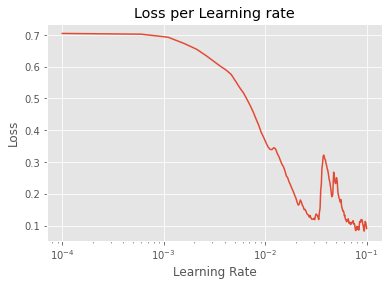

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

> Though maybe not very easy to spot, we do see some signs of overfitting in the training accuracy and loss plot. It's fairly obivious that that accuracies converge. That is; the model seems to get better at predicting on the training set, but not on the validation set. 

> A tell tale sign of overfit is the validation loss which is creeping up during the last epochs. Again this means the model manages to reduce the loss on the training set, but is doing the oposite on the validation set. Now we need to be careful, we have been using a one_cycle_fit, which uses a variable learning rate. In the middle of the cycle as the learning rate increases, it's not abnormal that the goes up a bit. But toward the end of the cycle it should normally not or at least not to the extent in this example.

Epoch 010/010: 100%|██████████| 3631/3631 [00:16<00:00, 222.67it/s, train_loss=0.018, train_acc=0.994, val_loss=0.0455, val_acc=0.994]


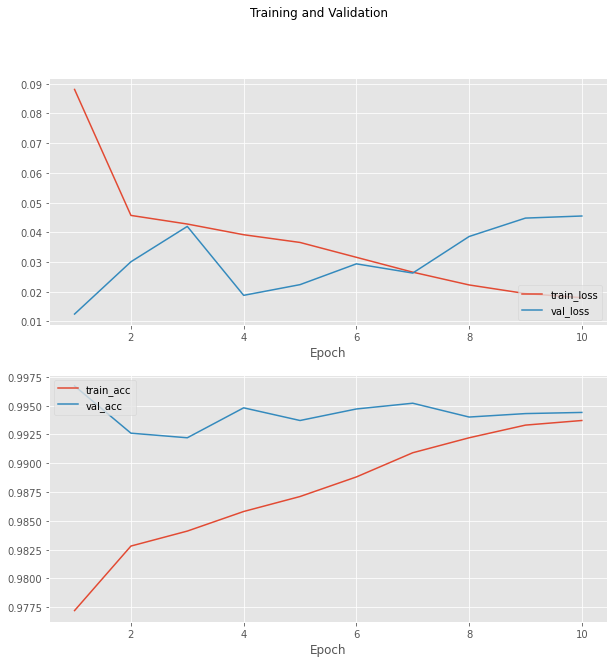

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data

> Test the model on the test set, it is data that was not seen during training and allows us to validate model results. And here we see the clear effect of the overfitting, this model does really well in saying where the fraud is NOT, but it's really not all that good at finding it. But the effect may just as well have been the other way around, the model good have gotten really good at saying where the fraud is, but dragged in a ton of false postives.

Testing in 782 steps: 100%|██████████| 782/782 [00:01<00:00, 730.18it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.97      0.54      0.69      1074

    accuracy                           0.99    100000
   macro avg       0.98      0.77      0.84    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9271
ap score  : 0.7644
-----------------------------------------------------


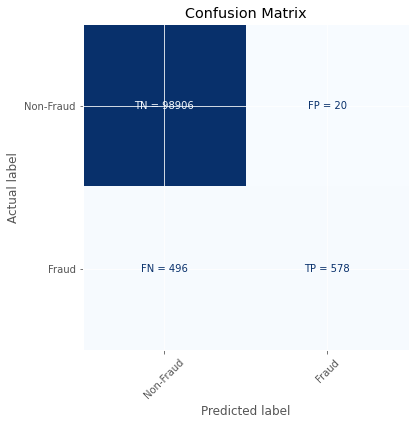

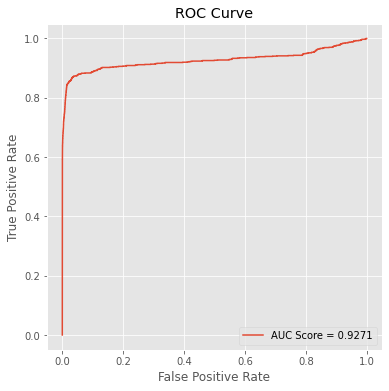

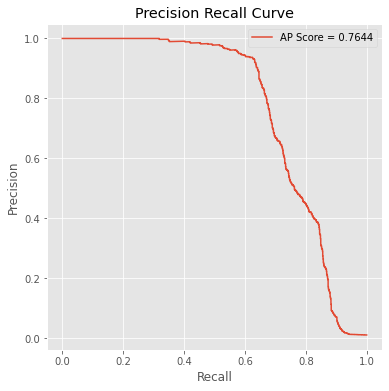

In [26]:
test_ds = pt.NumpyListDataSet(learning_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

# Conclusion
This was an example of things going wrong, when training Neural Nets we have to be on the constant look-out for over-fit, it's not always all that easy to spot, it can sometimes occur relatively quickly, and can have devastating effects on the performance of the model.

This model overfitted easier and more than previous models because;
- We used __binary input__ which makes is a tad easier to single out rows as opposed to embeddings.
- We reduced the __dropout rate__ at various layers
- We added parameters (i.e. gave the model __more capacity__)